In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.simplefilter("ignore", category=UserWarning)

import os
os.environ['OMP_NUM_THREADS'] = '1'


In [34]:
df = pd.read_csv('updated_dataset (1).csv')

In [35]:
df.columns

Index(['ID', 'Age', 'Gender', 'Race', 'BMI', 'Date of Admission',
       'Date of Hospital Discharge', 'PEG', 'TRACH', 'PEG ORDERS PLACED',
       'TRACH ORDERS PLACED', 'PEG DATE', 'TRACH DATE', 'PEG TIME',
       'TRACH TIME', 'PEG SERVICE', 'TRACH SERVICE', 'Discharge Disposition',
       'Discharge Status Code', 'GCS', 'GCS Qualifier', 'ISS',
       '#CO-MORBIDITIES', 'ICU LOS Days', 'Hospital LOS Days',
       '#Of total complications', 'Date Decannulation', 'Date of oral intake',
       'Date of Death', 'Date of readmission', 'Comorbidities List',
       'Charlson_Comorbidity_Index', 'DischargeGCS', 'VAP',
       'Total_Neutrophils', 'Total_Lymphocytes', 'NLR', 'Skull_Base_Fracture',
       'Skull_Vault_Fracture', 'Hematoma', 'Subdural_Hematoma',
       'Epidural_Hematoma', 'Intracerebral_Hemorrhage', 'Hemorrhage',
       'Subarachnoid_Hemorrhage', 'Intraventricular_Hemorrhage', 'Brain_Edema',
       'Contusion_Type', 'Contusion', 'DAI', 'Pneumocephalus',
       'Cranial_Nerve_In

In [36]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, chi2_contingency

# Load dataset
df = pd.read_csv('updated_dataset.csv')

# Convert date columns to datetime
date_columns = ['Date of Admission', 'Date of Hospital Discharge', 'PEG ORDERS PLACED', 
                'TRACH ORDERS PLACED', 'PEG DATE', 'TRACH DATE', 
                'Date Decannulation', 'Date of oral intake']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Drop rows where 'Hospital LOS Days' is less than 0
df = df[df['Hospital LOS Days'] >= 0]

# Create the binary PLOS category (0 = Normal LOS ≤ 24 days, 1 = PLOS > 24 days)
df['Hospital_LOS_Category'] = pd.cut(df['Hospital LOS Days'],
                                     bins=[-np.inf, 24, np.inf],
                                     labels=[0, 1]).astype(int)

# Separate the data into prolonged LOS and normal LOS
prolonged_los = df[df['Hospital_LOS_Category'] == 1]
normal_los = df[df['Hospital_LOS_Category'] == 0]

# Define the features to analyze
features = ['Age', 'Gender', 'Race', 'BMI','GCS', 'ISS', 'Charlson_Comorbidity_Index']

# Initialize a list to store the results
results = []

# Perform statistical tests for each feature
for feature in features:
    if df[feature].dtype in [np.int64, np.float64]:  
        # Perform t-test for numerical features
        stat, p_value = ttest_ind(prolonged_los[feature].dropna(), normal_los[feature].dropna())
        test_type = "t-test"
        mean_plos = prolonged_los[feature].mean()
        mean_normal = normal_los[feature].mean()
    else:
        # Perform chi-square test for categorical features
        contingency_table = pd.crosstab(df[feature], df['Hospital_LOS_Category'])
        stat, p_value, _, _ = chi2_contingency(contingency_table)
        test_type = "chi2"
        mean_plos = prolonged_los[feature].value_counts(normalize=True).to_dict()
        mean_normal = normal_los[feature].value_counts(normalize=True).to_dict()

    # Store results
    results.append([feature, test_type, mean_plos, mean_normal, stat, p_value, p_value < 0.05])

# Convert the results to a DataFrame
results_df = pd.DataFrame(results, columns=['Feature', 'Test', 'PLOS Value', 'Normal LOS Value', 'Statistic', 'P-value', 'Significant'])

# Print the results directly in table format
print(results_df.to_string(index=False))


                   Feature   Test                                                                                                                                                                                 PLOS Value                                                                                                          Normal LOS Value  Statistic  P-value  Significant
                       Age t-test                                                                                                                                                                                  41.713568                                                                                                                 51.852459  -3.688463 0.000275         True
                    Gender   chi2                                                                                                                                         {'M': 0.7336683417085427, 'F': 0.2663316582914573}                            

# Classification

In [37]:
#  dataset
df = pd.read_csv('updated_dataset (1).csv')

#  date columns to datetime
date_columns = ['Date of Admission', 'Date of Hospital Discharge', 'PEG ORDERS PLACED', 'TRACH ORDERS PLACED', 'PEG DATE', 'TRACH DATE', 'Date Decannulation', 'Date of oral intake']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Drop rows where 'Hospital LOS Days' is less than 0
df = df[df['Hospital LOS Days'] >= 0]

#  differences in days
df['PEG_Duration'] = (df['Date of oral intake'] - df['PEG DATE']).dt.days
df['PEG_Days_Difference'] = (df['PEG DATE'] - df['PEG ORDERS PLACED']).dt.days
df['PEG_ORDER_to_ADMISSION'] = (df['PEG ORDERS PLACED'] - df['Date of Admission']).dt.days
df['Trach_ORDER_to_ADMISSION'] = (df['TRACH ORDERS PLACED'] - df['Date of Admission']).dt.days
df['Trach_Days_Difference'] = (df['TRACH DATE'] - df['TRACH ORDERS PLACED']).dt.days
df['Trach_Duration'] = (df['Date Decannulation'] - df['TRACH DATE']).dt.days

# Categorize 'Hospital LOS'
df['Hospital_LOS_Category'] = pd.cut(df['Hospital LOS Days'],
                                         bins=[-np.inf, 24, np.inf],
                                         labels=[0, 1])


# Selected features
features = ['Age', 'Gender', 'Race', 'BMI', 'GCS', 
            'ISS', 'Charlson_Comorbidity_Index'
            ]
X = df[features]
y = df['Hospital_LOS_Category']

# Encode categorical features
categorical_features = ['Gender', 'Race']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Age', 'BMI', 'GCS', 'ISS', 'Charlson_Comorbidity_Index']),
        ('cat', OneHotEncoder(), categorical_features)])


In [38]:
# Calculate median and IQR for LOS in each group
grouped = df.groupby('Hospital_LOS_Category')['Hospital LOS Days'].agg(['median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
grouped.columns = ['Median', '25th Percentile', '75th Percentile']
print(grouped)


                       Median  25th Percentile  75th Percentile
Hospital_LOS_Category                                          
0                        16.0             11.0             20.0
1                        44.0             33.0             70.0


C:\Users\shrin\AppData\Local\Temp\ipykernel_36500\2404699857.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('Hospital_LOS_Category')['Hospital LOS Days'].agg(['median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])


In [39]:
y.value_counts()

Hospital_LOS_Category
1    199
0     64
Name: count, dtype: int64

In [80]:
import pandas as pd
import numpy as np

# Define numerical and categorical features
numerical_cols = ['Age', 'BMI', 'GCS', 'ISS', 'Charlson_Comorbidity_Index']
categorical_cols = ['Gender', 'Race']

# Function to summarize numerical data
def summarize_numerical(series):
    median = series.median()
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    return f"{median:.1f} ({q1:.1f}–{q3:.1f})"

# Function to summarize categorical data
def summarize_categorical(series):
    counts = series.value_counts(dropna=False)
    total = counts.sum()
    summary = {}
    for level in counts.index:
        label = f"{series.name}_{level}"
        pct = 100 * counts[level] / total
        summary[label] = f"{counts[level]} ({pct:.1f}%)"
    return summary

# Initialize dictionaries
summary_all = {}
summary_typical = {}
summary_plos = {}

# Full cohort
for col in numerical_cols:
    summary_all[col] = summarize_numerical(df[col])
for col in categorical_cols:
    summary_all.update(summarize_categorical(df[col]))

# Typical LOS subgroup (category == 0)
typical_df = df[df['Hospital_LOS_Category'] == 0]
for col in numerical_cols:
    summary_typical[col] = summarize_numerical(typical_df[col])
for col in categorical_cols:
    summary_typical.update(summarize_categorical(typical_df[col]))

# Prolonged LOS subgroup (category == 1)
plos_df = df[df['Hospital_LOS_Category'] == 1]
for col in numerical_cols:
    summary_plos[col] = summarize_numerical(plos_df[col])
for col in categorical_cols:
    summary_plos.update(summarize_categorical(plos_df[col]))

# Merge all into single DataFrame
all_keys = sorted(set(summary_all.keys()) | set(summary_typical.keys()) | set(summary_plos.keys()))
table1 = pd.DataFrame(index=all_keys)
table1['All Patients'] = table1.index.map(summary_all.get)
table1['Typical LOS'] = table1.index.map(summary_typical.get)
table1['Prolonged LOS'] = table1.index.map(summary_plos.get)

# Display
print("\n📊 Table 1: Baseline Characteristics by LOS Group")
display(table1)



📊 Table 1: Baseline Characteristics by LOS Group


,All Patients,Typical LOS,Prolonged LOS
Age,41.0 (26.0–60.0),58.0 (31.8–65.2),38.0 (26.0–54.5)
BMI,24.3 (21.1–28.4),24.9 (21.0–30.1),24.1 (21.2–27.9)
Charlson_Comorbidity_Index,1.0 (0.0–3.0),2.0 (1.0–4.0),1.0 (0.0–2.0)
GCS,3.0 (3.0–11.0),6.0 (3.0–14.0),3.0 (3.0–8.0)
Gender_0,69 (26.2%),16 (25.0%),53 (26.6%)
Gender_1,194 (73.8%),48 (75.0%),146 (73.4%)
ISS,27.0 (22.0–37.0),25.0 (19.8–30.0),29.0 (24.0–38.0)
Race_ASIAN,3 (1.1%),None,3 (1.5%)
Race_BLACK,48 (18.3%),6 (9.4%),42 (21.1%)
Race_HISP/LATINO,3 (1.1%),None,3 (1.5%)


In [40]:
df.columns

Index(['ID', 'Age', 'Gender', 'Race', 'BMI', 'Date of Admission',
       'Date of Hospital Discharge', 'PEG', 'TRACH', 'PEG ORDERS PLACED',
       'TRACH ORDERS PLACED', 'PEG DATE', 'TRACH DATE', 'PEG TIME',
       'TRACH TIME', 'PEG SERVICE', 'TRACH SERVICE', 'Discharge Disposition',
       'Discharge Status Code', 'GCS', 'GCS Qualifier', 'ISS',
       '#CO-MORBIDITIES', 'ICU LOS Days', 'Hospital LOS Days',
       '#Of total complications', 'Date Decannulation', 'Date of oral intake',
       'Date of Death', 'Date of readmission', 'Comorbidities List',
       'Charlson_Comorbidity_Index', 'DischargeGCS', 'VAP',
       'Total_Neutrophils', 'Total_Lymphocytes', 'NLR', 'Skull_Base_Fracture',
       'Skull_Vault_Fracture', 'Hematoma', 'Subdural_Hematoma',
       'Epidural_Hematoma', 'Intracerebral_Hemorrhage', 'Hemorrhage',
       'Subarachnoid_Hemorrhage', 'Intraventricular_Hemorrhage', 'Brain_Edema',
       'Contusion_Type', 'Contusion', 'DAI', 'Pneumocephalus',
       'Cranial_Nerve_In

### XGBoost


In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier

#  dataset
df = pd.read_csv('updated_dataset (1).csv')

#  date columns to datetime
date_columns = ['Date of Admission', 'Date of Hospital Discharge', 'PEG ORDERS PLACED', 'TRACH ORDERS PLACED', 'PEG DATE', 'TRACH DATE', 'Date Decannulation', 'Date of oral intake']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Drop rows where 'Hospital LOS Days' is less than 0
df = df[df['Hospital LOS Days'] >= 0]

#  differences in days
df['PEG_Duration'] = (df['Date of oral intake'] - df['PEG DATE']).dt.days
df['PEG_Days_Difference'] = (df['PEG DATE'] - df['PEG ORDERS PLACED']).dt.days
df['PEG_ORDER_to_ADMISSION'] = (df['PEG ORDERS PLACED'] - df['Date of Admission']).dt.days
df['Trach_ORDER_to_ADMISSION'] = (df['TRACH ORDERS PLACED'] - df['Date of Admission']).dt.days
df['Trach_Days_Difference'] = (df['TRACH DATE'] - df['TRACH ORDERS PLACED']).dt.days
df['Trach_Duration'] = (df['Date Decannulation'] - df['TRACH DATE']).dt.days

# Categorize 'Hospital LOS'
df['Hospital_LOS_Category'] = pd.cut(df['Hospital LOS Days'],
                                         bins=[-np.inf, 24, np.inf],
                                         labels=[0, 1])


# Selected features
features = ['Age', 'Gender', 'Race', 'BMI','GCS', 
            'ISS', 'Charlson_Comorbidity_Index'
            ]
X = df[features]
y = df['Hospital_LOS_Category']

# Encode categorical features
categorical_features = ['Gender', 'Race']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Age', 'BMI', 'GCS', 'ISS', 'Charlson_Comorbidity_Index']),
        ('cat', OneHotEncoder(), categorical_features)])


# XGBoost model
XGB_model = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1,
    random_state=42
)

# Pipeline including SMOTE 
XGB_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', XGB_model)
])

#  GridSearchCV 
param_grid = {
    'model__n_estimators': [50, 100, 200, 500],
    'model__learning_rate': [0.001, 0.01, 0.1, 0.3],
    'model__max_depth': [3, 5, 7, 10],
    # 'model__min_child_weight': [1, 3, 5, 7],
    'model__gamma': [0, 0.1, 0.2, 0.3],
    'model__subsample': [0.6, 1.0],
    # 'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__reg_alpha': [0, 0.01, 0.1, 1],
    'model__reg_lambda': [0.1, 1, 10]
}

#  StratifiedKFold cross-validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#  grid search
grid_search = GridSearchCV(XGB_pipeline, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X, y)

best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")


# Evaluate 
XGB_y_pred = grid_search.predict(X)
XGB_y_prob = grid_search.predict_proba(X)[:, 1]
print("Classification Report:")
print(classification_report(y, XGB_y_pred))


roc_auc = roc_auc_score(y, XGB_y_prob)
print(f"AUC Score: {roc_auc:.4f}")


f1 = f1_score(y, XGB_y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")


print("Confusion Matrix:")
print(confusion_matrix(y, XGB_y_pred))


Fitting 5 folds for each of 6144 candidates, totalling 30720 fits
Best Parameters: {'model__gamma': 0, 'model__learning_rate': 0.01, 'model__max_depth': 10, 'model__n_estimators': 100, 'model__reg_alpha': 0, 'model__reg_lambda': 10, 'model__subsample': 0.6}
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.77      0.66        64
           1       0.92      0.82      0.87       199

    accuracy                           0.81       263
   macro avg       0.75      0.79      0.76       263
weighted avg       0.84      0.81      0.82       263

AUC Score: 0.8894
F1 Score: 0.8177
Confusion Matrix:
[[ 49  15]
 [ 35 164]]


In [42]:

# Evaluate 
XGB_y_pred = grid_search.predict(X)
XGB_y_prob = grid_search.predict_proba(X)[:, 1]
print("Classification Report:")
print(classification_report(y, XGB_y_pred))


roc_auc = roc_auc_score(y, XGB_y_prob)
print(f"AUC Score: {roc_auc:.4f}")


f1 = f1_score(y, XGB_y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")


print("Confusion Matrix:")
print(confusion_matrix(y, XGB_y_pred))

accuracy = accuracy_score(y, XGB_y_pred)
print(f"Accuracy: {accuracy:.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.77      0.66        64
           1       0.92      0.82      0.87       199

    accuracy                           0.81       263
   macro avg       0.75      0.79      0.76       263
weighted avg       0.84      0.81      0.82       263

AUC Score: 0.8894
F1 Score: 0.8177
Confusion Matrix:
[[ 49  15]
 [ 35 164]]
Accuracy: 0.8099


### SVR

In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.svm import SVC

#  dataset
df = pd.read_csv('updated_dataset (1).csv')

#  date columns to datetime
date_columns = ['Date of Admission', 'Date of Hospital Discharge', 'PEG ORDERS PLACED', 'TRACH ORDERS PLACED', 'PEG DATE', 'TRACH DATE', 'Date Decannulation', 'Date of oral intake']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Drop rows where 'Hospital LOS Days' is less than 0
df = df[df['Hospital LOS Days'] >= 0]

#  differences in days
df['PEG_Duration'] = (df['Date of oral intake'] - df['PEG DATE']).dt.days
df['PEG_Days_Difference'] = (df['PEG DATE'] - df['PEG ORDERS PLACED']).dt.days
df['PEG_ORDER_to_ADMISSION'] = (df['PEG ORDERS PLACED'] - df['Date of Admission']).dt.days
df['Trach_ORDER_to_ADMISSION'] = (df['TRACH ORDERS PLACED'] - df['Date of Admission']).dt.days
df['Trach_Days_Difference'] = (df['TRACH DATE'] - df['TRACH ORDERS PLACED']).dt.days
df['Trach_Duration'] = (df['Date Decannulation'] - df['TRACH DATE']).dt.days

# Categorize 'Hospital LOS'
df['Hospital_LOS_Category'] = pd.cut(df['Hospital LOS Days'],
                                         bins=[-np.inf, 24, np.inf],
                                         labels=[0, 1])


# Selected features
features = ['Age', 'Gender', 'Race', 'BMI', 'GCS', 
            'ISS', 'Charlson_Comorbidity_Index'            ]
X = df[features]
y = df['Hospital_LOS_Category']

# Encode categorical features
categorical_features = ['Gender', 'Race']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Age', 'BMI', 'GCS', 'ISS', 'Charlson_Comorbidity_Index']),
        ('cat', OneHotEncoder(), categorical_features)])

# Define the SVC model
svm_model = SVC(probability=True, random_state=42)

# Pipeline including SMOTE for handling imbalance
SVM_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', svm_model)
])

# Define the parameter grid for GridSearchCV
SVM_param_grid = {
    'model__C': [0.1, 1, 10, 100],
    'model__kernel': ['linear', 'rbf'],
    'model__gamma': ['scale', 'auto', 0.01, 0.001],
    'model__class_weight': [None, 'balanced']
}

# Cross-validation setup (5-fold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(SVM_pipeline, SVM_param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X, y)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Evaluate the best model
# Ensure predictions are aligned
SVM_y_prob = grid_search.predict_proba(X)[:, 1]  # Full dataset predictions
SVM_y_pred = grid_search.predict(X)


# Print evaluation metrics
print("Classification Report:")
print(classification_report(y, SVM_y_pred))

roc_auc = roc_auc_score(y, SVM_y_prob)
print(f"AUC Score: {roc_auc:.4f}")

f1 = f1_score(y, SVM_y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")

print("Confusion Matrix:")
print(confusion_matrix(y, SVM_y_pred))
accuracy = accuracy_score(y, SVM_y_pred)
print(f"Accuracy: {accuracy:.4f}")



Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Parameters: {'model__C': 0.1, 'model__class_weight': None, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.73      0.52        64
           1       0.88      0.65      0.75       199

    accuracy                           0.67       263
   macro avg       0.64      0.69      0.64       263
weighted avg       0.77      0.67      0.70       263

AUC Score: 0.7680
F1 Score: 0.6957
Confusion Matrix:
[[ 47  17]
 [ 69 130]]
Accuracy: 0.6730


In [44]:
len(SVM_y_pred)

263

### ANN

In [45]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix, accuracy_score
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Load dataset
df = pd.read_csv('updated_dataset (1).csv')

# Convert date columns to datetime
date_columns = [
    'Date of Admission', 'Date of Hospital Discharge', 'PEG ORDERS PLACED', 'TRACH ORDERS PLACED',
    'PEG DATE', 'TRACH DATE', 'Date Decannulation', 'Date of oral intake'
]
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Drop rows where 'Hospital LOS Days' is less than 0
df = df[df['Hospital LOS Days'] >= 0]

# Feature engineering
df['PEG_Duration'] = (df['Date of oral intake'] - df['PEG DATE']).dt.days
df['PEG_Days_Difference'] = (df['PEG DATE'] - df['PEG ORDERS PLACED']).dt.days
df['PEG_ORDER_to_ADMISSION'] = (df['PEG ORDERS PLACED'] - df['Date of Admission']).dt.days
df['Trach_ORDER_to_ADMISSION'] = (df['TRACH ORDERS PLACED'] - df['Date of Admission']).dt.days
df['Trach_Days_Difference'] = (df['TRACH DATE'] - df['TRACH ORDERS PLACED']).dt.days
df['Trach_Duration'] = (df['Date Decannulation'] - df['TRACH DATE']).dt.days

# Create binary target for classification
df['Hospital_LOS_Category'] = pd.cut(df['Hospital LOS Days'], bins=[-np.inf, 24, np.inf], labels=[0, 1])

# Define input features and target variable
features = ['Age', 'Gender', 'Race', 'BMI', 'GCS', 'ISS', 'Charlson_Comorbidity_Index']
X = df[features]
y = df['Hospital_LOS_Category'].astype(int)

# Preprocessing: Standardize numerical features and one-hot encode categorical features
categorical_features = ['Gender', 'Race']
numerical_features = ['Age', 'BMI', 'GCS', 'ISS', 'Charlson_Comorbidity_Index']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

X = preprocessor.fit_transform(X)

# Define the ANN model
def create_ann_model(hidden_units=64, dropout_rate=0.3, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(hidden_units, input_dim=X.shape[1], activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(hidden_units // 2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap ANN model using KerasClassifier
ann_model = KerasClassifier(
    model=create_ann_model,
    random_state=42,
    verbose=0
)

# Define parameter grid for GridSearchCV
param_grid = {
    'model__hidden_units': [32, 64, 128],     # Number of units in the first hidden layer
    'model__dropout_rate': [0.2, 0.3, 0.4],  # Dropout rate for regularization
    'model__learning_rate': [0.001, 0.01],   # Learning rate for optimization
    'batch_size': [16, 32],                  # Batch size during training
    'epochs': [50, 100]                      # Number of epochs for training
}

# Perform GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=ann_model, param_grid=param_grid, cv=cv, scoring='roc_auc', verbose=2, n_jobs=-1)
grid_search.fit(X, y)

# Get the best parameters and the best model
print(f"Best Parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

# Evaluate the best ANN model on the full dataset
ANN_y_prob = best_model.predict_proba(X)[:, 1]
ANN_y_pred = (ANN_y_prob > 0.5).astype(int)

print("Classification Report (Full Dataset):")
print(classification_report(y, ANN_y_pred))

roc_auc = roc_auc_score(y, ANN_y_prob)
print(f"AUC Score (Full Dataset): {roc_auc:.4f}")

f1 = f1_score(y, ANN_y_pred, average='weighted')
print(f"F1 Score (Full Dataset): {f1:.4f}")

print("Confusion Matrix (Full Dataset):")
print(confusion_matrix(y, ANN_y_pred))





Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'batch_size': 16, 'epochs': 100, 'model__dropout_rate': 0.4, 'model__hidden_units': 64, 'model__learning_rate': 0.001}
Classification Report (Full Dataset):
              precision    recall  f1-score   support

           0       0.77      0.36      0.49        64
           1       0.82      0.96      0.89       199

    accuracy                           0.82       263
   macro avg       0.80      0.66      0.69       263
weighted avg       0.81      0.82      0.79       263

AUC Score (Full Dataset): 0.8655
F1 Score (Full Dataset): 0.7917
Confusion Matrix (Full Dataset):
[[ 23  41]
 [  7 192]]


In [46]:
accuracy = accuracy_score(y, ANN_y_pred)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.8175


In [47]:
from tensorflow.keras.utils import plot_model

# Visualize the ANN Model
def visualize_ann_model(model):
    plot_model(
        model,
        to_file="ann_model.png",  # Saves the model visualization as a file
        show_shapes=True,         # Displays the shapes of layers
        show_layer_names=True     # Shows layer names
    )
    print("ANN model visualization saved as ann_model.png")

# Example Usage
visualize_ann_model(create_ann_model())


ANN model visualization saved as ann_model.png


In [48]:
from graphviz import Digraph

def visualize_detailed_ann():
    dot = Digraph(format="png", graph_attr={"rankdir": "LR"})
    
    # Input Layer
    input_layer_nodes = [f"Input {i}" for i in range(1, 17)]  # 16 features
    for node in input_layer_nodes:
        dot.node(node, shape="circle", style="filled", color="lightblue")
    
    # First Hidden Layer (64 neurons)
    hidden_layer_1_nodes = [f"H1_{i}" for i in range(1, 65)]
    for node in hidden_layer_1_nodes:
        dot.node(node, shape="circle", style="filled", color="lightgreen")
    
    # Second Hidden Layer (32 neurons)
    hidden_layer_2_nodes = [f"H2_{i}" for i in range(1, 33)]
    for node in hidden_layer_2_nodes:
        dot.node(node, shape="circle", style="filled", color="yellow")
    
    # Output Layer (1 neuron)
    dot.node("Output", shape="circle", style="filled", color="red")
    
    # Add connections
    # From Input Layer to First Hidden Layer
    for i_node in input_layer_nodes:
        for h1_node in hidden_layer_1_nodes:
            dot.edge(i_node, h1_node, arrowhead="vee")
    
    # From First Hidden Layer to Second Hidden Layer
    for h1_node in hidden_layer_1_nodes:
        for h2_node in hidden_layer_2_nodes:
            dot.edge(h1_node, h2_node, arrowhead="vee")
    
    # From Second Hidden Layer to Output Layer
    for h2_node in hidden_layer_2_nodes:
        dot.edge(h2_node, "Output", arrowhead="vee")
    
    # Render and save
    dot.render("ann_detailed_visualization", cleanup=True)
    print("Detailed ANN visualization saved as 'ann_detailed_visualization.png'")

# Run the visualization function
visualize_detailed_ann()


Detailed ANN visualization saved as 'ann_detailed_visualization.png'


## Diversity

In [49]:
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy.stats import pearsonr

# Bootstrap sampling function
def bootstrap_sample(X, y, n_samples=5):
    np.random.seed(42)
    indices = [np.random.choice(range(len(y)), size=len(y), replace=True) for _ in range(n_samples)]
    return indices

# Bias-Variance Calculation
def calculate_bias_variance_with_risk(models, X, y, n_samples=5):
    indices = bootstrap_sample(X, y, n_samples)
    predictions = {model_name: [] for model_name in models}

    for idx_set in indices:
        X_train, y_train = X[idx_set], y[idx_set]
        for model_name, model in models.items():
            model.fit(X_train, y_train)
            predictions[model_name].append(model.predict(X))

    bias_variance_risk = {}
    for model_name, preds in predictions.items():
        preds = np.array(preds)
        avg_pred = preds.mean(axis=0)
        bias = np.mean((avg_pred - y) ** 2)
        variance = np.mean(np.var(preds, axis=0))
        diversity = np.mean([np.var([pred for pred in preds]) for pred in preds.T])
        expected_risk = bias + variance - diversity

        bias_variance_risk[model_name] = {
            'bias': bias,
            'variance': variance,
            'diversity': diversity,
            'expected_risk': expected_risk,
        }
    return bias_variance_risk

# Diversity Calculation
def calculate_diversity(models, X, y):
    predictions = {}
    for model_name, model in models.items():
        predictions[model_name] = model.predict(X)
    
    diversity_metrics = {}
    model_names = list(models.keys())
    for i, model1 in enumerate(model_names):
        for j, model2 in enumerate(model_names):
            if i < j:
                # Disagreement Measure
                disagree = np.mean(predictions[model1] != predictions[model2])
                # Correlation Coefficient
                corr, _ = pearsonr(predictions[model1], predictions[model2])
                # Q-Statistic
                q_stat = (np.sum(predictions[model1] == y) * np.sum(predictions[model2] == y) - 
                          np.sum(predictions[model1] != y) * np.sum(predictions[model2] != y))
                q_stat /= len(y) ** 2

                diversity_metrics[f"{model1} vs {model2}"] = {
                    'disagreement': disagree,
                    'correlation': corr,
                    'q_statistic': q_stat
                }
    return diversity_metrics

# Example Usage
models = {
    'XGBoost': XGB_model,
    'SVM': svm_model,
    'ANN': ann_model  # Ensure ann_model is wrapped appropriately for scikit-learn
}

# Bias-Variance Analysis
bias_variance_results = calculate_bias_variance_with_risk(models, X, y)
print("Bias-Variance Results:")
print(bias_variance_results)

# Diversity Analysis
diversity_results = calculate_diversity(models, X, y)
print("Diversity Results:")
print(diversity_results)


Bias-Variance Results:
{'XGBoost': {'bias': 0.041216730038022814, 'variance': 0.06144486692015211, 'diversity': 0.1723222831037025, 'expected_risk': -0.06966068614552759}, 'SVM': {'bias': 0.15863117870722435, 'variance': 0.05353612167300381, 'diversity': 0.09929072272260696, 'expected_risk': 0.1128765776576212}, 'ANN': {'bias': 0.2705703422053232, 'variance': 0.02524714828897339, 'diversity': 0.107443507929853, 'expected_risk': 0.18837398256444363}}
Diversity Results:
{'XGBoost vs SVM': {'disagreement': 0.1634980988593156, 'correlation': 0.4523146025245371, 'q_statistic': 0.6920152091254753}, 'XGBoost vs ANN': {'disagreement': 0.26996197718631176, 'correlation': 0.0315939468319055, 'q_statistic': 0.6007604562737643}, 'SVM vs ANN': {'disagreement': 0.1596958174904943, 'correlation': 0.03901195912674422, 'q_statistic': 0.5057034220532319}}


In [50]:
from sklearn.base import clone

# Snapshot + Dropout Ensemble
def snapshot_dropout_ensemble(base_model, X, y, n_snapshots=5, dropout_rate=0.3):
    snapshots = []
    for i in range(n_snapshots):
        # Clone and apply dropout for each snapshot
        model = clone(base_model)
        if hasattr(model, 'dropout_rate'):
            model.dropout_rate = dropout_rate  # Ensure ANN model adjusts dropout rate
        model.fit(X, y)
        snapshots.append(model)
    return snapshots

# Predict using Snapshot Ensemble
def snapshot_predict(snapshots, X):
    predictions = np.array([model.predict(X) for model in snapshots])
    return predictions.mean(axis=0)

# Weighted Averaging Ensemble
def weighted_average_ensemble(models, weights, X):
    predictions = np.array([model.predict_proba(X)[:, 1] for model in models])
    return np.dot(weights, predictions)

# Example: XGBoost + ANN Weighted Ensemble
weights = [0.6, 0.4]
models = [XGB_model, ann_model]
ensemble_probs = weighted_average_ensemble(models, weights, X)
ensemble_preds = (ensemble_probs > 0.5).astype(int)

# Evaluate
print("Weighted Averaging Ensemble:")
print(classification_report(y, ensemble_preds))
print(f"AUC Score: {roc_auc_score(y, ensemble_probs):.4f}")

f1 = f1_score(y, ensemble_preds, average='weighted')
print(f"F1 Score (Full Dataset): {f1:.4f}")

print("Confusion Matrix (Full Dataset):")
print(confusion_matrix(y, ensemble_preds))

accuracy = accuracy_score(y, ensemble_preds)
print(f"Accuracy: {accuracy:.4f}")


Weighted Averaging Ensemble:
              precision    recall  f1-score   support

           0       0.81      0.73      0.77        64
           1       0.92      0.94      0.93       199

    accuracy                           0.89       263
   macro avg       0.86      0.84      0.85       263
weighted avg       0.89      0.89      0.89       263

AUC Score: 0.8739
F1 Score (Full Dataset): 0.8917
Confusion Matrix (Full Dataset):
[[ 47  17]
 [ 11 188]]
Accuracy: 0.8935


In [51]:
# Weighted Averaging with SVM
weights = [0.5, 0.3, 0.2]  # Adjusted for XGBoost, ANN, and SVM
models = [XGB_model, ann_model, svm_model]
weighted_probs = weighted_average_ensemble(models, weights, X)
weighted_preds = (weighted_probs > 0.5).astype(int)

print("Weighted Averaging Ensemble with SVM:")
print(classification_report(y, weighted_preds))
print(f"AUC Score: {roc_auc_score(y, weighted_probs):.4f}")


f1 = f1_score(y, weighted_preds, average='weighted')
print(f"F1 Score (Full Dataset): {f1:.4f}")

print("Confusion Matrix (Full Dataset):")
print(confusion_matrix(y, weighted_preds))

accuracy = accuracy_score(y, weighted_preds)
print(f"Accuracy: {accuracy:.4f}")

Weighted Averaging Ensemble with SVM:
              precision    recall  f1-score   support

           0       0.84      0.73      0.78        64
           1       0.92      0.95      0.94       199

    accuracy                           0.90       263
   macro avg       0.88      0.84      0.86       263
weighted avg       0.90      0.90      0.90       263

AUC Score: 0.8586
F1 Score (Full Dataset): 0.8988
Confusion Matrix (Full Dataset):
[[ 47  17]
 [  9 190]]
Accuracy: 0.9011


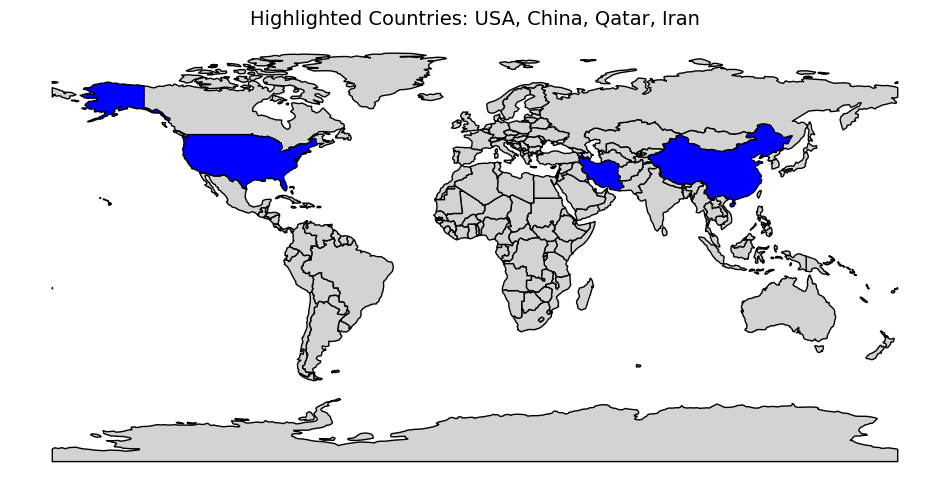

In [52]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Download Natural Earth dataset (Country Boundaries)
world = gpd.read_file("https://raw.githubusercontent.com/nvkelso/natural-earth-vector/master/geojson/ne_110m_admin_0_countries.geojson")

# Define countries to highlight
highlighted_countries = ["United States of America", "China", "Qatar", "Iran"]

# Ensure column name consistency
if "ADMIN" in world.columns:  # Some datasets use "ADMIN" instead of "name"
    name_column = "ADMIN"
elif "name" in world.columns:
    name_column = "name"
else:
    raise KeyError("No valid country name column found in dataset.")

# Create a color column for the map
world['color'] = 'lightgray'  # Default color for all countries
world.loc[world[name_column].isin(highlighted_countries), 'color'] = 'blue'  # Highlighted countries

# Plot the map
fig, ax = plt.subplots(figsize=(12, 6))
world.plot(ax=ax, color=world['color'], edgecolor='black')

# Set Mercator projection style
ax.set_title("Highlighted Countries: USA, China, Qatar, Iran", fontsize=14)
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

# Show the map
plt.show()


In [55]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

# Manually define feature names
numerical_features = ['Age', 'BMI', 'GCS', 'ISS', 'Charlson_Comorbidity_Index']
categorical_features = ['Gender', 'Race']

# Assume categorical features are one-hot encoded; define dummy feature names for illustration
# Replace these with actual one-hot encoded names based on your dataset structure
one_hot_feature_names = [
    f"{cat}_{val}" for cat in categorical_features for val in range(X.shape[1] - len(numerical_features))
]

# Combine all feature names
feature_names = numerical_features + one_hot_feature_names[: X.shape[1] - len(numerical_features)]

# Permutation Importance Function
def permutation_importance(ensemble_model, X, y, weights, baseline_score, metric=roc_auc_score):
    """
    Calculate permutation-based feature importance for an ensemble model.
    
    Parameters:
        ensemble_model (list): List of individual models in the ensemble.
        X (array-like): Feature matrix.
        y (array-like): Target array.
        weights (list): Ensemble weights for the models.
        baseline_score (float): Baseline metric score of the ensemble.
        metric (callable): Metric to evaluate performance, e.g., roc_auc_score.

    Returns:
        feature_importance (list): Importance values for each feature.
    """
    feature_importance = []
    X_copy = X.copy()
    
    for col in range(X.shape[1]):
        # Shuffle the feature column
        original_col = X_copy[:, col].copy()
        np.random.shuffle(X_copy[:, col])
        
        # Compute weighted ensemble predictions
        weighted_probs = np.average(
            [model.predict_proba(X_copy)[:, 1] for model in ensemble_model], 
            axis=0, weights=weights
        )
        score = metric(y, weighted_probs)
        
        # Importance is the drop in performance
        importance = baseline_score - score
        feature_importance.append(importance)
        
        # Restore the original column for the next iteration
        X_copy[:, col] = original_col
    
    return feature_importance

# Calculate baseline performance of the ensemble
weighted_probs = np.average(
    [model.predict_proba(X)[:, 1] for model in models], 
    axis=0, weights=weights
)
baseline_auc = roc_auc_score(y, weighted_probs)

# Compute feature importance
importances = permutation_importance(models, X, y, weights, baseline_auc)

# Display feature importance
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print(importance_df)


                       Feature  Importance
0                          Age    0.088646
1                          BMI    0.087861
3                          ISS    0.069724
2                          GCS    0.027403
4   Charlson_Comorbidity_Index    0.023398
11                    Gender_6    0.010600
6                     Gender_1    0.003847
5                     Gender_0    0.001492
9                     Gender_4    0.000079
10                    Gender_5   -0.000236
8                     Gender_3   -0.000393
7                     Gender_2   -0.000864


In [74]:
# Load dataset
df = pd.read_csv('updated_dataset (1).csv')

# Convert date columns to datetime
date_columns = [
    'Date of Admission', 'Date of Hospital Discharge', 'PEG ORDERS PLACED', 'TRACH ORDERS PLACED',
    'PEG DATE', 'TRACH DATE', 'Date Decannulation', 'Date of oral intake'
]
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Drop rows where 'Hospital LOS Days' is less than 0
df = df[df['Hospital LOS Days'] >= 0]

# Feature engineering
df['PEG_Duration'] = (df['Date of oral intake'] - df['PEG DATE']).dt.days
df['PEG_Days_Difference'] = (df['PEG DATE'] - df['PEG ORDERS PLACED']).dt.days
df['PEG_ORDER_to_ADMISSION'] = (df['PEG ORDERS PLACED'] - df['Date of Admission']).dt.days
df['Trach_ORDER_to_ADMISSION'] = (df['TRACH ORDERS PLACED'] - df['Date of Admission']).dt.days
df['Trach_Days_Difference'] = (df['TRACH DATE'] - df['TRACH ORDERS PLACED']).dt.days
df['Trach_Duration'] = (df['Date Decannulation'] - df['TRACH DATE']).dt.days

# Create binary target for classification
df['Hospital_LOS_Category'] = pd.cut(df['Hospital LOS Days'], bins=[-np.inf, 24, np.inf], labels=[0, 1])

# Define input features and target variable
features = ['Age', 'Gender', 'Race', 'BMI', 'GCS', 'ISS', 'Charlson_Comorbidity_Index']
X = df[features]
y = df['Hospital_LOS_Category'].astype(int)

# Preprocessing: Standardize numerical features and one-hot encode categorical features
categorical_features = ['Gender', 'Race']
numerical_features = ['Age', 'BMI', 'GCS', 'ISS', 'Charlson_Comorbidity_Index']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

In [75]:
# Fit preprocessor
preprocessor.fit(X)

# Get names of encoded categorical features
cat_transformer = preprocessor.named_transformers_['cat']
onehot_feature_names = cat_transformer.get_feature_names_out(categorical_features)

# Final full feature name list
feature_names = numerical_features + list(onehot_feature_names)


In [76]:
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)


In [77]:
importance_df

,Feature,Importance
0,Age,0.088646
1,BMI,0.087861
3,ISS,0.069724
2,GCS,0.027403
4,Charlson_Comorbidity_Index,0.023398
11,Race_WHITE,0.010600
6,Gender_1,0.003847
5,Gender_0,0.001492
9,Race_HISP/LATINO,0.000079
10,Race_OTHER,-0.000236


In [78]:
race_importance = importance_df[importance_df['Feature'].str.startswith('Race_')]['Importance'].sum()
gender_importance = importance_df[importance_df['Feature'].str.startswith('Gender_')]['Importance'].sum()

print(f"Total Importance for Race: {race_importance:.5f}")
print(f"Total Importance for Gender: {gender_importance:.5f}")


Total Importance for Race: 0.00919
Total Importance for Gender: 0.00534


In [56]:
from sklearn.preprocessing import OneHotEncoder

# Get feature names from the preprocessor
ohe = preprocessor.named_transformers_['cat']  # Extract the OneHotEncoder
categorical_feature_names = ohe.get_feature_names_out(categorical_features)

# Combine categorical and numerical feature names
all_feature_names = numerical_features + list(categorical_feature_names)

# Print feature names
print("Feature Names and Categories:")
for idx, name in enumerate(all_feature_names):
    print(f"{idx}: {name}")

# Handle negative importance: Sort by absolute importance
importance_df['Absolute Importance'] = importance_df['Importance'].abs()
importance_df_sorted = importance_df.sort_values(by="Absolute Importance", ascending=False)

# Display sorted feature importance
print("\nSorted Feature Importances (by absolute value):")
print(importance_df_sorted)


Feature Names and Categories:
0: Age
1: BMI
2: GCS
3: ISS
4: Charlson_Comorbidity_Index
5: Gender_0
6: Gender_1
7: Race_ASIAN
8: Race_BLACK
9: Race_HISP/LATINO
10: Race_OTHER
11: Race_WHITE

Sorted Feature Importances (by absolute value):
                       Feature  Importance  Absolute Importance
0                          Age    0.088646             0.088646
1                          BMI    0.087861             0.087861
3                          ISS    0.069724             0.069724
2                          GCS    0.027403             0.027403
4   Charlson_Comorbidity_Index    0.023398             0.023398
11                    Gender_6    0.010600             0.010600
6                     Gender_1    0.003847             0.003847
5                     Gender_0    0.001492             0.001492
7                     Gender_2   -0.000864             0.000864
8                     Gender_3   -0.000393             0.000393
10                    Gender_5   -0.000236             0.

In [57]:
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, classification_report, confusion_matrix
import numpy as np

# Generate Snapshot Ensembles for ANN
snapshots_ann = snapshot_dropout_ensemble(ann_model, X, y, n_snapshots=50, dropout_rate=0.5)

# Predict probabilities for Snapshot ANN
snapshot_probs = snapshot_predict(snapshots_ann, X)  # Directly get probabilities from snapshot ensemble

# Predict probabilities for XGBoost
xgb_probs = XGB_model.predict_proba(X)[:, 1]  # Get probabilities for the positive class from XGBoost

# Combine probabilities using weighted averaging
weights = [0.6, 0.4]  # Weight for XGBoost and Snapshot ANN, respectively
snapshot_ensemble_probs = np.average([xgb_probs, snapshot_probs], axis=0, weights=weights)

# Convert probabilities to class predictions
snapshot_ensemble_preds = (snapshot_ensemble_probs > 0.5).astype(int)

# Calculate Metrics
snapshot_ensemble_auc = roc_auc_score(y, snapshot_ensemble_probs)
snapshot_ensemble_f1 = f1_score(y, snapshot_ensemble_preds, average="weighted")
snapshot_ensemble_accuracy = accuracy_score(y, snapshot_ensemble_preds)
snapshot_ensemble_conf_matrix = confusion_matrix(y, snapshot_ensemble_preds)

# Print Classification Report
print("XGBoost + Snapshot ANN Weighted Averaging Ensemble Metrics:")
print(f"AUC Score: {snapshot_ensemble_auc:.4f}")
print(f"F1 Score: {snapshot_ensemble_f1:.4f}")
print(f"Accuracy: {snapshot_ensemble_accuracy:.4f}")
print("Confusion Matrix:")
print(snapshot_ensemble_conf_matrix)

# Full Classification Report
print("\nFull Classification Report:")
print(classification_report(y, snapshot_ensemble_preds))


XGBoost + Snapshot ANN Weighted Averaging Ensemble Metrics:
AUC Score: 0.8721
F1 Score: 0.8952
Accuracy: 0.9011
Confusion Matrix:
[[ 42  22]
 [  4 195]]

Full Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.66      0.76        64
           1       0.90      0.98      0.94       199

    accuracy                           0.90       263
   macro avg       0.91      0.82      0.85       263
weighted avg       0.90      0.90      0.90       263



In [58]:
accuracy = accuracy_score(y, snapshot_ensemble_preds)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.9011


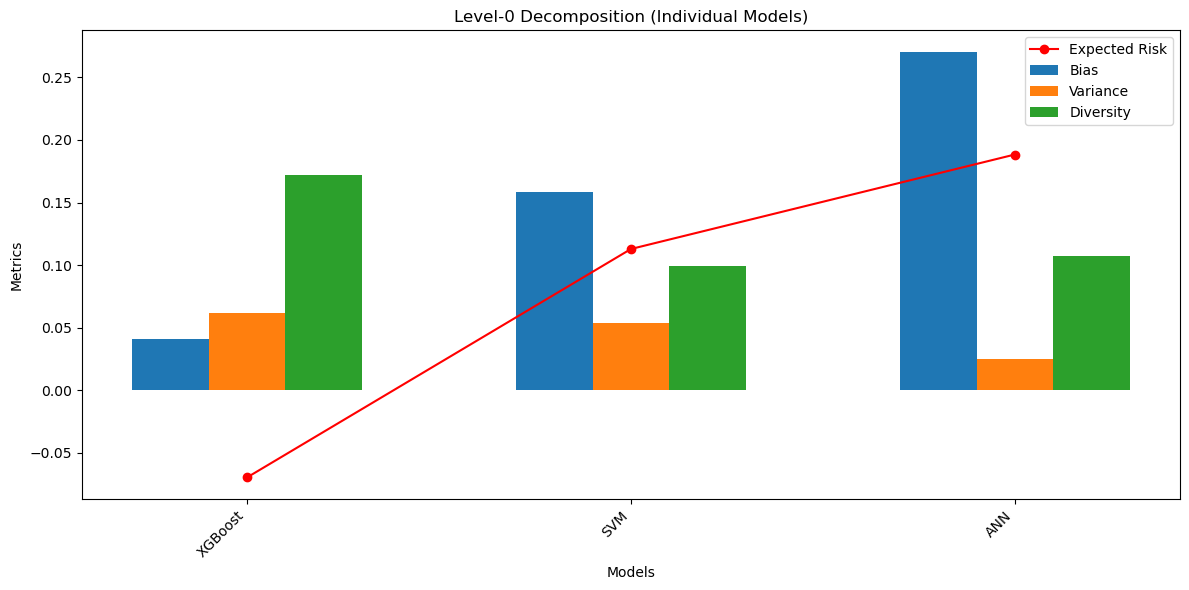

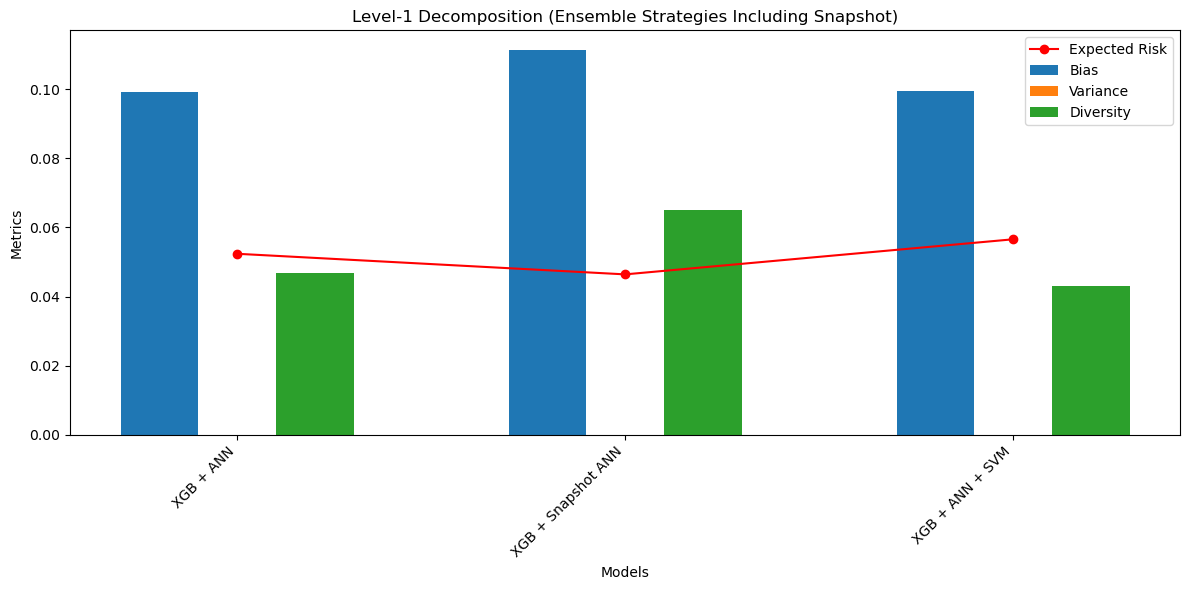

In [59]:

import matplotlib.pyplot as plt

# Visualization Function
def plot_decomposition(results, title):
    categories = list(results.keys())
    bias = [results[cat]['bias'] for cat in categories]
    variance = [results[cat]['variance'] for cat in categories]
    diversity = [results[cat]['diversity'] for cat in categories]
    risk = [results[cat]['expected_risk'] for cat in categories]

    x = np.arange(len(categories))
    width = 0.2

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width, bias, width, label='Bias')
    ax.bar(x, variance, width, label='Variance')
    ax.bar(x + width, diversity, width, label='Diversity')
    ax.plot(x, risk, label='Expected Risk', color='red', marker='o')

    ax.set_xlabel('Models')
    ax.set_ylabel('Metrics')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=45, ha='right')
    ax.legend()
    plt.tight_layout()
    plt.show()

# Updated calculate_decomposition to handle raw predictions
def calculate_decomposition(models, X, y, n_samples=5):
    indices = bootstrap_sample(X, y, n_samples)
    predictions = {model_name: [] for model_name in models}

    for idx_set in indices:
        X_train, y_train = X[idx_set], y[idx_set]
        for model_name, model in models.items():
            if isinstance(model, list):  # Snapshot Ensemble Case
                # Directly use the precomputed snapshot ensemble predictions
                snapshots = model
                snapshot_preds = snapshot_predict(snapshots, X)
                predictions[model_name].append(snapshot_preds)
            elif isinstance(model, np.ndarray):  # Precomputed Predictions (e.g., snapshot_probs)
                predictions[model_name].append(model)
            else:  # Regular scikit-learn model
                model_clone = clone(model)
                model_clone.fit(X_train, y_train)
                predictions[model_name].append(model_clone.predict(X))

    results = {}
    for model_name, preds in predictions.items():
        preds = np.array(preds)
        avg_pred = preds.mean(axis=0)
        bias = np.mean((avg_pred - y) ** 2)
        variance = np.mean(np.var(preds, axis=0))
        diversity = np.mean([np.var([pred for pred in preds]) for pred in preds.T])
        expected_risk = bias + variance - diversity

        results[model_name] = {
            'bias': bias,
            'variance': variance,
            'diversity': diversity,
            'expected_risk': expected_risk
        }
    return results


# Generate Snapshot Ensembles for ANN
snapshots_ann = snapshot_dropout_ensemble(ann_model, X, y, n_snapshots=5, dropout_rate=0.3)

# Get predictions for Snapshot Ensembles
snapshot_probs = snapshot_predict(snapshots_ann, X)  # Precomputed probabilities

# Define Level-0 Models (Individual Models)
models_level_0 = {
    'XGBoost': XGB_model,
    'SVM': svm_model,
    'ANN': ann_model
}

# Define Level-1 Ensembles (Ensemble Strategies)
models_level_1 = {
    'XGB + ANN': np.average(
        [XGB_model.predict_proba(X)[:, 1], ann_model.predict_proba(X)[:, 1]], axis=0, weights=[0.6, 0.4]
    ),
    'XGB + Snapshot ANN': np.average(
        [XGB_model.predict_proba(X)[:, 1], snapshot_probs], axis=0, weights=[0.6, 0.4]
    ),
    'XGB + ANN + SVM': np.average(
        [XGB_model.predict_proba(X)[:, 1], ann_model.predict_proba(X)[:, 1], svm_model.predict_proba(X)[:, 1]],
        axis=0,
        weights=[0.5, 0.3, 0.2]
    )
}

# Level-0 Analysis
level_0_results = calculate_decomposition(models_level_0, X, y)
plot_decomposition(level_0_results, "Level-0 Decomposition (Individual Models)")

# Level-1 Analysis
level_1_results = calculate_decomposition(models_level_1, X, y)
plot_decomposition(level_1_results, "Level-1 Decomposition (Ensemble Strategies Including Snapshot)")


In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
from scikit_posthocs import critical_difference_diagram
from sklearn.metrics import roc_auc_score

# Prepare AUC Scores for Level-0 Models
level_0_probabilities = {
    'XGBoost': XGB_y_prob,
    'SVM': SVM_y_prob,
    'ANN': ANN_y_prob,
}

# Prepare AUC Scores for Level-1 Models
level_1_probabilities = {
    'Weighted Avg (XGB + ANN)': ensemble_probs,
    'Weighted Avg (XGB + ANN + SVM)': weighted_probs,
    'Snapshot + Dropout (ANN)': snapshot_ensemble_probs,
}

# Compute AUC Scores for Level-0 Models
level_0_auc = {model: roc_auc_score(y, probs) for model, probs in level_0_probabilities.items()}
print("Level-0 AUC Scores:", level_0_auc)

# Compute AUC Scores for Level-1 Models
level_1_auc = {model: roc_auc_score(y, probs) for model, probs in level_1_probabilities.items()}
print("Level-1 AUC Scores:", level_1_auc)

# Perform Friedman Test for Level-0
level_0_scores = list(level_0_probabilities.values())
level_0_stat, level_0_p_value = friedmanchisquare(*level_0_scores)
print(f"Level-0 Friedman Test Statistic: {level_0_stat}, P-value: {level_0_p_value}")

# Perform Post-Hoc Conover Test for Level-0
level_0_matrix = np.array(level_0_scores).T
level_0_posthoc = sp.posthoc_conover_friedman(level_0_matrix)
print("Level-0 Conover Post-Hoc Test Results:")
print(level_0_posthoc)

# Perform Friedman Test for Level-1
level_1_scores = list(level_1_probabilities.values())
level_1_stat, level_1_p_value = friedmanchisquare(*level_1_scores)
print(f"Level-1 Friedman Test Statistic: {level_1_stat}, P-value: {level_1_p_value}")

# Perform Post-Hoc Conover Test for Level-1
level_1_matrix = np.array(level_1_scores).T
level_1_posthoc = sp.posthoc_conover_friedman(level_1_matrix)
print("Level-1 Conover Post-Hoc Test Results:")
print(level_1_posthoc)

# Helper Function for Ranks and Critical Difference Diagrams
def plot_critical_difference_diagram(auc_scores, posthoc_results, title):
    # Convert AUC Scores to Ranks
    ranked_auc = {model: len(auc_scores) - sorted(auc_scores.values()).index(score) for model, score in auc_scores.items()}
    
    # Plot the Critical Difference Diagram
    plt.figure(figsize=(14, 6))
    critical_difference_diagram(
        ranks=ranked_auc,
        sig_matrix=posthoc_results,
        ax=None,
        label_fmt_left="{label} ({rank:.2g})",
        label_fmt_right="",
        label_props={'fontsize': 12, 'weight': 'bold'},
        marker_props={'s': 100},  # Increase marker size
        crossbar_props={'linewidth': 2.0},  # Make bars thicker
        color_palette=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"],  # Custom colors
        text_h_margin=0.03,  # Add margin between labels and bars
        left_only=True  # Align all labels to one side
    )
    plt.title(title, fontsize=16, weight='bold')
    plt.xlabel("Average Rank", fontsize=14)
    plt.tight_layout()
    plt.show()



Level-0 AUC Scores: {'XGBoost': 0.8894472361809045, 'SVM': 0.7679805276381909, 'ANN': 0.8654993718592965}
Level-1 AUC Scores: {'Weighted Avg (XGB + ANN)': 0.8739007537688441, 'Weighted Avg (XGB + ANN + SVM)': 0.858589824120603, 'Snapshot + Dropout (ANN)': 0.8720948492462312}
Level-0 Friedman Test Statistic: 284.1749049429659, P-value: 1.959762503364782e-62
Level-0 Conover Post-Hoc Test Results:
              0             1             2
0  1.000000e+00  2.757232e-01  4.056423e-71
1  2.757232e-01  1.000000e+00  1.529655e-76
2  4.056423e-71  1.529655e-76  1.000000e+00
Level-1 Friedman Test Statistic: 322.9125475285173, P-value: 7.593311836391646e-71
Level-1 Conover Post-Hoc Test Results:
               0             1              2
0   1.000000e+00  3.665689e-37  2.550836e-110
1   3.665689e-37  1.000000e+00   7.687788e-43
2  2.550836e-110  7.687788e-43   1.000000e+00


In [61]:
import numpy as np
import pandas as pd
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
from sklearn.metrics import f1_score, accuracy_score

# Define predictions and ground truth
y = np.array(y)  # Ground truth
XGB_y_pred = np.array(XGB_y_pred)  # Predictions for XGBoost
SVM_y_pred = np.array(SVM_y_pred)  # Predictions for SVM
ANN_y_pred = np.array(ANN_y_pred)  # Predictions for ANN
ensemble_preds = np.array(ensemble_preds)  # Predictions for Weighted Avg (XGB + ANN)
weighted_preds = np.array(weighted_preds)  # Predictions for Weighted Avg (XGB + ANN + SVM)
snapshot_ensemble_preds = np.array(snapshot_ensemble_preds)  # Predictions for Snapshot + Dropout (ANN)

# Level-0 models
level_0_probabilities = {
    'XGBoost': XGB_y_pred,
    'SVM': SVM_y_pred,
    'ANN': ANN_y_pred,
}

# Level-1 models
level_1_probabilities = {
    'Weighted Avg (XGB + ANN)': ensemble_preds,
    'Weighted Avg (XGB + ANN + SVM)': weighted_preds,
    'Snapshot + Dropout (ANN)': snapshot_ensemble_preds,
}

# Calculate F1 Scores for Level-0 Models
level_0_f1_scores = {model: f1_score(y, preds, average='weighted') for model, preds in level_0_probabilities.items()}
print("Level-0 F1 Scores:", level_0_f1_scores)

# Calculate F1 Scores for Level-1 Models
level_1_f1_scores = {model: f1_score(y, preds, average='weighted') for model, preds in level_1_probabilities.items()}
print("Level-1 F1 Scores:", level_1_f1_scores)

# Perform Friedman Test for Level-0
level_0_f1_values = list(level_0_probabilities.values())
level_0_stat, level_0_p_value = friedmanchisquare(*level_0_f1_values)
print(f"Level-0 Friedman Test Statistic: {level_0_stat}, P-value: {level_0_p_value}")

# Perform Post-Hoc Conover Test for Level-0
level_0_f1_matrix = np.array(level_0_f1_values).T
level_0_posthoc = sp.posthoc_conover_friedman(level_0_f1_matrix)
print("Level-0 Conover Post-Hoc Test Results:")
print(level_0_posthoc)

# Perform Friedman Test for Level-1
level_1_f1_values = list(level_1_probabilities.values())
level_1_stat, level_1_p_value = friedmanchisquare(*level_1_f1_values)
print(f"Level-1 Friedman Test Statistic: {level_1_stat}, P-value: {level_1_p_value}")

# Perform Post-Hoc Conover Test for Level-1
level_1_f1_matrix = np.array(level_1_f1_values).T
level_1_posthoc = sp.posthoc_conover_friedman(level_1_f1_matrix)
print("Level-1 Conover Post-Hoc Test Results:")
print(level_1_posthoc)


Level-0 F1 Scores: {'XGBoost': 0.817702004013791, 'SVM': 0.6956646177815874, 'ANN': 0.7916655430610613}
Level-1 F1 Scores: {'Weighted Avg (XGB + ANN)': 0.8917087308057616, 'Weighted Avg (XGB + ANN + SVM)': 0.8988193572958225, 'Snapshot + Dropout (ANN)': 0.8951909782232976}
Level-0 Friedman Test Statistic: 104.96296296296245, P-value: 1.6128062229796974e-23
Level-0 Conover Post-Hoc Test Results:
              0             1             2
0  1.000000e+00  3.042196e-05  4.093044e-12
1  3.042196e-05  1.000000e+00  1.126911e-26
2  4.093044e-12  1.126911e-26  1.000000e+00
Level-1 Friedman Test Statistic: 17.714285714281623, P-value: 0.000142361230021548
Level-1 Conover Post-Hoc Test Results:
          0         1         2
0  1.000000  0.506537  0.000076
1  0.506537  1.000000  0.000951
2  0.000076  0.000951  1.000000


In [62]:
import numpy as np
import pandas as pd
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
from sklearn.metrics import accuracy_score


# Calculate Accuracy Scores for Level-0 Models
level_0_accuracy_scores = {model: accuracy_score(y, preds) for model, preds in level_0_probabilities.items()}
print("Level-0 Accuracy Scores:", level_0_accuracy_scores)

# Calculate Accuracy Scores for Level-1 Models
level_1_accuracy_scores = {model: accuracy_score(y, preds) for model, preds in level_1_probabilities.items()}
print("Level-1 Accuracy Scores:", level_1_accuracy_scores)

# Perform Friedman Test for Level-0
level_0_accuracy_values = list(level_0_probabilities.values())
level_0_stat, level_0_p_value = friedmanchisquare(*level_0_accuracy_values)
print(f"Level-0 Friedman Test Statistic: {level_0_stat}, P-value: {level_0_p_value}")

# Perform Post-Hoc Conover Test for Level-0
level_0_accuracy_matrix = np.array(level_0_accuracy_values).T
level_0_posthoc = sp.posthoc_conover_friedman(level_0_accuracy_matrix)
print("Level-0 Conover Post-Hoc Test Results:")
print(level_0_posthoc)

# Perform Friedman Test for Level-1
level_1_accuracy_values = list(level_1_probabilities.values())
level_1_stat, level_1_p_value = friedmanchisquare(*level_1_accuracy_values)
print(f"Level-1 Friedman Test Statistic: {level_1_stat}, P-value: {level_1_p_value}")

# Perform Post-Hoc Conover Test for Level-1
level_1_accuracy_matrix = np.array(level_1_accuracy_values).T
level_1_posthoc = sp.posthoc_conover_friedman(level_1_accuracy_matrix)
print("Level-1 Conover Post-Hoc Test Results:")
print(level_1_posthoc)


Level-0 Accuracy Scores: {'XGBoost': 0.8098859315589354, 'SVM': 0.6730038022813688, 'ANN': 0.8174904942965779}
Level-1 Accuracy Scores: {'Weighted Avg (XGB + ANN)': 0.8935361216730038, 'Weighted Avg (XGB + ANN + SVM)': 0.9011406844106464, 'Snapshot + Dropout (ANN)': 0.9011406844106464}
Level-0 Friedman Test Statistic: 104.96296296296245, P-value: 1.6128062229796974e-23
Level-0 Conover Post-Hoc Test Results:
              0             1             2
0  1.000000e+00  3.042196e-05  4.093044e-12
1  3.042196e-05  1.000000e+00  1.126911e-26
2  4.093044e-12  1.126911e-26  1.000000e+00
Level-1 Friedman Test Statistic: 17.714285714281623, P-value: 0.000142361230021548
Level-1 Conover Post-Hoc Test Results:
          0         1         2
0  1.000000  0.506537  0.000076
1  0.506537  1.000000  0.000951
2  0.000076  0.000951  1.000000


Friedman Test Statistic: 15.098039215686265, P-value: 0.009951543448127575
Conover Post-Hoc Test Results:
                         XGBoost       SVM       ANN  XGBoost + ANN  \
XGBoost                 1.000000  0.014203  0.117303       0.548456   
SVM                     0.014203  1.000000  0.320351       0.003332   
ANN                     0.117303  0.320351  1.000000       0.034921   
XGBoost + ANN           0.548456  0.003332  0.034921       1.000000   
XGBoost + ANN + SVM     0.235095  0.000722  0.008861       0.548456   
XGBoost + Snapshot ANN  0.235095  0.000722  0.008861       0.548456   

                        XGBoost + ANN + SVM  XGBoost + Snapshot ANN  
XGBoost                            0.235095                0.235095  
SVM                                0.000722                0.000722  
ANN                                0.008861                0.008861  
XGBoost + ANN                      0.548456                0.548456  
XGBoost + ANN + SVM                1.000000   

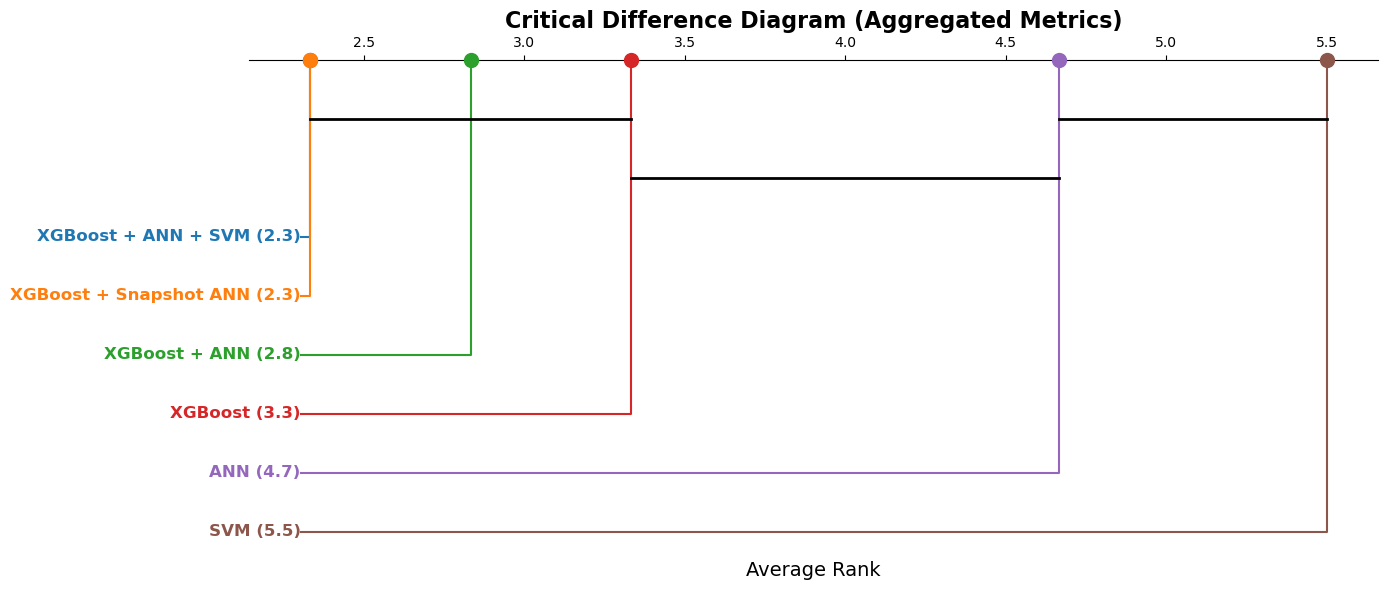

In [63]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
from scikit_posthocs import critical_difference_diagram

# Define helper function to calculate metrics
def calculate_metrics(y_true, y_probs, threshold=0.5):
    y_pred = (y_probs > threshold).astype(int)
    auc = roc_auc_score(y_true, y_probs)
    f1 = f1_score(y_true, y_pred, average='weighted')
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    
    # Specificity calculation
    cm = confusion_matrix(y_true, y_pred)
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if cm.shape == (2, 2) else 0.0
    
    return [auc, f1, acc, precision, recall, specificity]

# Assuming these variables contain predicted probabilities and true labels
model_probs = {
    'XGBoost': XGB_y_prob,
    'SVM': SVM_y_prob,
    'ANN': ANN_y_prob,
    'XGBoost + ANN': ensemble_probs,
    'XGBoost + ANN + SVM': weighted_probs,
    'XGBoost + Snapshot ANN': snapshot_ensemble_probs
}

# True labels (binary)
y_true = y  # Replace with your true labels

# Calculate metrics for each model
metrics = ['AUC', 'F1 Score', 'Accuracy', 'Precision', 'Recall', 'Specificity']
scores = {}
for model_name, y_probs in model_probs.items():
    scores[model_name] = calculate_metrics(y_true, y_probs)

# Convert to DataFrame
df_scores = pd.DataFrame(scores, index=metrics)

# Calculate ranks for each metric
df_ranks = df_scores.rank(axis=1, ascending=False)
average_ranks = df_ranks.mean(axis=0)

# Perform Friedman Test
stat, p_value = friedmanchisquare(*df_ranks.values.T)
print(f"Friedman Test Statistic: {stat}, P-value: {p_value}")

# Ensure correct input for Post-Hoc Conover Test (align indices)
matrix = df_ranks.values
posthoc = sp.posthoc_conover_friedman(matrix)
posthoc.columns = df_scores.columns  # Assign model names as column labels
posthoc.index = df_scores.columns  # Assign model names as row labels

print("Conover Post-Hoc Test Results:")
print(posthoc)

# Convert average ranks into a dictionary for CD diagram
ranked_auc = average_ranks.to_dict()

# Plot Critical Difference Diagram
plt.figure(figsize=(14, 6))
critical_difference_diagram(
    ranks=ranked_auc,
    sig_matrix=posthoc,  # Pass labeled DataFrame
    ax=None,
    label_fmt_left="{label} ({rank:.2g})",
    label_fmt_right="",
    label_props={'fontsize': 12, 'weight': 'bold'},
    marker_props={'s': 100},  # Increase marker size
    crossbar_props={'linewidth': 2.0},  # Make bars thicker
    color_palette=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"],  # Custom colors
    text_h_margin=0.03,  # Add margin between labels and bars
    left_only=True  # Align all labels to one side
)
plt.title("Critical Difference Diagram (Aggregated Metrics)", fontsize=16, weight='bold')
plt.xlabel("Average Rank", fontsize=14)
plt.tight_layout()
plt.show()


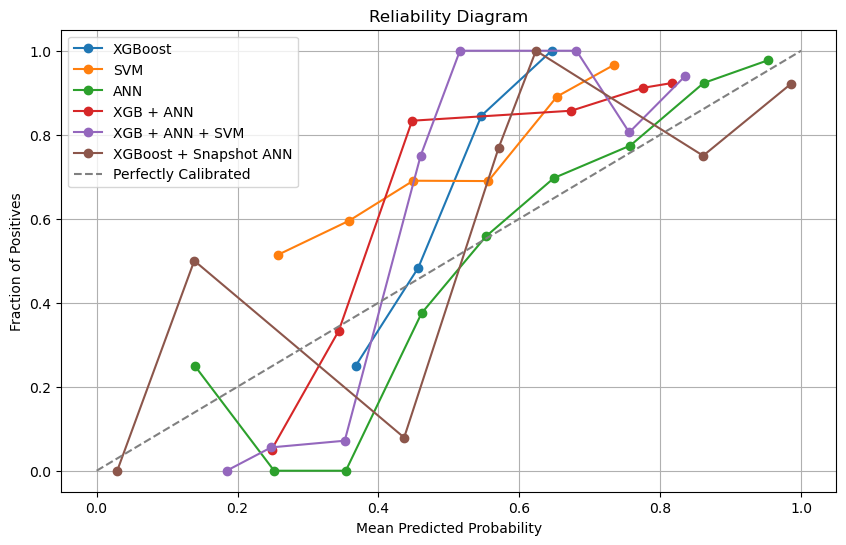

In [64]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Reliability Diagram for Ensembles
def plot_reliability_diagram(y_true, model_probs, model_labels):
    plt.figure(figsize=(10, 6))
    for probs, label in zip(model_probs, model_labels):
        fraction_of_positives, mean_predicted_value = calibration_curve(y_true, probs, n_bins=10, strategy='uniform')
        plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label=label)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Reliability Diagram')
    plt.legend()
    plt.grid()
    plt.show()

# Example Usage
model_probs = [XGB_y_prob, SVM_y_prob, ANN_y_prob, ensemble_probs, weighted_probs, snapshot_ensemble_probs]
model_labels = ['XGBoost', 'SVM', 'ANN', 'XGB + ANN', 'XGB + ANN + SVM', 'XGBoost + Snapshot ANN']
plot_reliability_diagram(y, model_probs, model_labels)


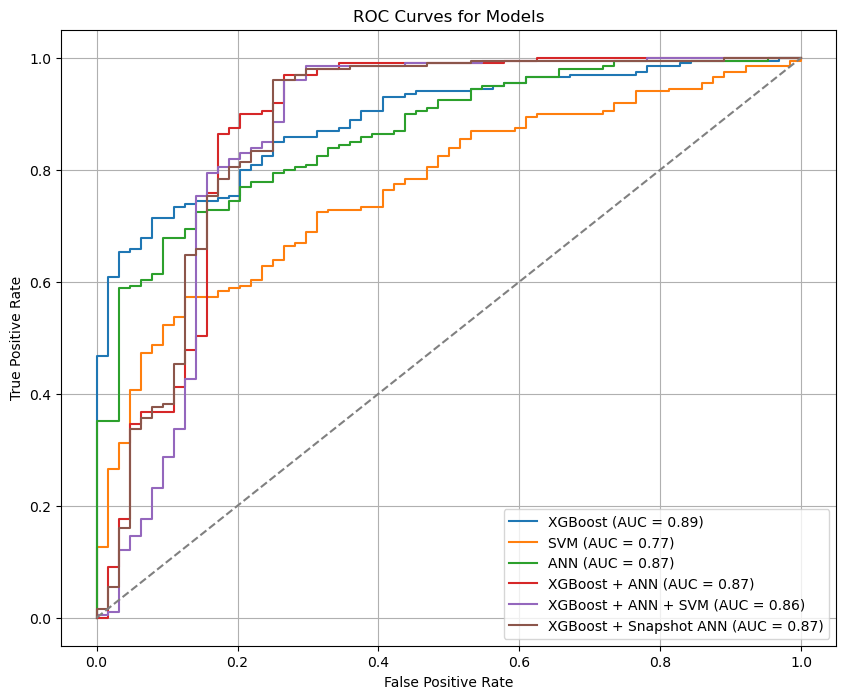

In [65]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Generate ROC curve data
models_data = {
    'XGBoost': XGB_y_prob,
    'SVM': SVM_y_prob,
    'ANN': ANN_y_prob,
    'XGBoost + ANN': ensemble_probs,
    'XGBoost + ANN + SVM': weighted_probs,
    'XGBoost + Snapshot ANN': snapshot_ensemble_probs
}

# Assuming `y` is the true labels
roc_curves = {}

for model_name, y_prob in models_data.items():
    fpr, tpr, _ = roc_curve(y, y_prob)
    roc_auc = auc(fpr, tpr)
    roc_curves[model_name] = {
        'fpr': fpr,
        'tpr': tpr,
        'auc': roc_auc
    }

# Plot ROC curves
plt.figure(figsize=(10, 8))
for model_name, data in roc_curves.items():
    plt.plot(data['fpr'], data['tpr'], label=f"{model_name} (AUC = {data['auc']:.2f})")

# Add diagonal line for random guessing
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Configure plot
plt.title('ROC Curves for Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [66]:
from sklearn.metrics import confusion_matrix

# Models predictions (replace with your model predictions)
models_predictions = {
    'XGBoost': XGB_y_pred,
    'SVM': SVM_y_pred,
    'ANN': ANN_y_pred,
    'Weighted Averaging (XGBoost + ANN)': ensemble_preds,
    'Weighted Averaging (XGBoost + ANN + SVM)': weighted_preds,
    'Snapshot': snapshot_ensemble_preds  # Replace with snapshot predictions
}

# Initialize a dictionary to store results
sensitivity_specificity = {}

# Iterate through each model and calculate sensitivity and specificity
for model_name, predictions in models_predictions.items():
    cm = confusion_matrix(y, predictions)  # Confusion matrix for the model
    TN, FP, FN, TP = cm.ravel()  # Extract values from the confusion matrix

    # Calculate sensitivity and specificity
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

    # Store results
    sensitivity_specificity[model_name] = {
        'Sensitivity': sensitivity,
        'Specificity': specificity
    }

    # Print results
    print(f"Model: {model_name}")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Sensitivity: {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}\n")

# Optionally: Convert to DataFrame for better display
import pandas as pd

sensitivity_specificity_df = pd.DataFrame(sensitivity_specificity).T
print(sensitivity_specificity_df)


Model: XGBoost
Confusion Matrix:
[[ 49  15]
 [ 35 164]]
Sensitivity: 0.8241
Specificity: 0.7656

Model: SVM
Confusion Matrix:
[[ 47  17]
 [ 69 130]]
Sensitivity: 0.6533
Specificity: 0.7344

Model: ANN
Confusion Matrix:
[[ 23  41]
 [  7 192]]
Sensitivity: 0.9648
Specificity: 0.3594

Model: Weighted Averaging (XGBoost + ANN)
Confusion Matrix:
[[ 47  17]
 [ 11 188]]
Sensitivity: 0.9447
Specificity: 0.7344

Model: Weighted Averaging (XGBoost + ANN + SVM)
Confusion Matrix:
[[ 47  17]
 [  9 190]]
Sensitivity: 0.9548
Specificity: 0.7344

Model: Snapshot
Confusion Matrix:
[[ 42  22]
 [  4 195]]
Sensitivity: 0.9799
Specificity: 0.6562

                                          Sensitivity  Specificity
XGBoost                                      0.824121     0.765625
SVM                                          0.653266     0.734375
ANN                                          0.964824     0.359375
Weighted Averaging (XGBoost + ANN)           0.944724     0.734375
Weighted Averaging (XGBoost + 